In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import spatial_efd
import math 
import signac
import numpy as np
import os.path
import similaritymeasures

In [2]:
# Defining number of input parameters and number of outputs in the feature 
num_samples = 150
num_harmonics = 20
num_input_parameter = 35

##### Exploring signac workspace
1. Extracts Surface Evolver parameters and corresponding EFD related shape features for the parameter screening

In [3]:
# Fetching project from signac workspace
project = signac.get_project()

LookupError: Unable to determine project id for path 'C:\Users\Nilay\Documents\GitHub\Tissue-Cartography\parameter_screening'.

In [4]:
""" This section of the code does the following tasks
1. Creating input and output training data for building surrogate models
2. The input data is stored in master_parameter_input array with shape [num_samples,num_parameters]
3. The output data is stored in master_parameter_output array with shape [num samples, 4 x num_harmonics]
4. The section additionally plots wing imaginal disc shape through reverse EFD  as a result of changes made in the parameter
"""

# Checking if data exists
doesDataFileExist = os.path.isfile("master_feature_output.npy")

# Loading datafiles if they exist
# Else fetching and preparing data from signac workspace
if doesDataFileExist == True:
    # Loading input parameters
    master_parameter_input_n = np.load('master_parameter_input_n.npy', )
    # Loading output EFD coefficients
    master_feature_output = np.load('master_feature_output.npy', )
else:
    # Initializing input and output data
    master_parameter_input = np.zeros([1, 35])
    master_feature_output = np.zeros([1,80])

    # Itearting throgh each job in workspace
    for job in project:

        isFile = os.path.isfile(job.fn("signac_job_document.json"))
        if isFile == True:
            # Fetching input parameters from the .json file containing setpoints
            input_param = job.statepoint()["parameter_model"]
            # Coverting array to a numpy array
            input_param = np.array(input_param)
            # Reshaping the array to concatenate to the master input 
            input_param_reshaped = np.reshape(input_param, (1, len(input_param)))
            # Vertical concatenation of the job specific input parameter list to the mster input data
            master_parameter_input = np.vstack((master_parameter_input,input_param_reshaped))

            # Fetching efd coefficients from the output data in signac
            efd_coeff = job.document.get("e_f_d")
            # Converting to numpy array
            efd_coeff = np.array(efd_coeff)
            # Converting efd coeff to xy data for visualization
            xt, yt = spatial_efd.inverse_transform(efd_coeff, harmonic=20)
            plt.plot(xt,yt,label=str(input_param[33]))
            plt.axes().set_aspect('equal', 'datalim')
            # Reshaping efd coeff in a shape of a row 
            efd_coeff = np.reshape(efd_coeff, (1,80))
            # Stacking output features for creating a master output feature matrix
            master_feature_output = np.vstack((master_feature_output,efd_coeff))


    plt.legend(loc='upper left',ncol = 2, prop={'size': 6})      
    plt.show()

    # Deleting the first row containing zeros
    master_feature_output = np.delete(master_feature_output, 0, 0)
    master_parameter_input = np.delete(master_parameter_input, 0, 0)

    # Renaming files for saving
    master_feature_output = master_feature_output
    master_parameter_input_n = master_parameter_input
    
    # saving files 
    np.save('master_parameter_input_n.npy', master_parameter_input_n)
    np.save('master_feature_output.npy', master_feature_output)



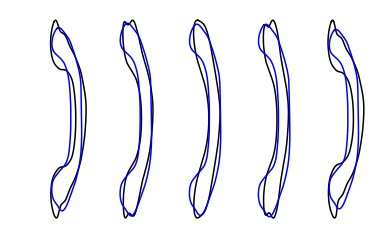

In [5]:
"""Visualizing shapes
"""
plt.close()


"""
STEP 3b: Extracting EFD coefficients from an experimental image
converting efd to pc1
"""
geometry_data = 'vertices_target.txt' 

if type(geometry_data) is str:
    # Checking if the file containing vertices coordinates are empty
    if os.stat(geometry_data).st_size != 0:
        a1 = []
        a2 = []
        
        with open(geometry_data) as f:
            # next(f)
            for line in f:
                data = line.split()
                a1.append(float(data[0]))
                a2.append(float(data[1]))
                

    else:
        a1 = 0
        a2 = 0
        
vpos_x_exp = a1
vpos_y_exp = a2

coeffs = spatial_efd.CalculateEFD(vpos_x_exp, vpos_y_exp, 20)
# Normalizing the coefficients against rotation and size


coeffs_exp, rotation = spatial_efd.normalize_efd(coeffs, size_invariant=True)

coeffs_exp_reshaped = np.reshape(coeffs,(80,))
# Reverse EFD for plotting the normalized tissue shape
xt_exp, yt_exp = spatial_efd.inverse_transform(coeffs, harmonic=20)
exp_data = np.zeros((300,2))
exp_data[:,0] = xt_exp
exp_data[:,1] = yt_exp

error_simulation_experimental_data = np.zeros(150)
for i in range(150):
    temp = master_feature_output[i,:]
    error_simulation_experimental_data[i] = np.linalg.norm(temp-coeffs_exp_reshaped) / np.linalg.norm(coeffs_exp_reshaped)
    temp2 = np.reshape(temp, (20,4))
    xt, yt = spatial_efd.inverse_transform(temp2, harmonic=20)
    sim_data = np.zeros((300,2))
    sim_data[:,0] = xt
    sim_data[:,1] = yt
    #error_simulation_experimental_data[i] = similaritymeasures.curve_length_measure(exp_data,sim_data)
    #plt.subplot(6,20,i+1)
    #plt.plot(xt,yt,color="black")
    #plt.plot(xt_exp,yt_exp,'blue')
    #plt.xticks(xt, " ")
    #plt.xticks(yt, " ")
    #plt.axis("off")
    #plt.axes().set_aspect('equal', 'datalim')
    #plt.axes().set_aspect('equal', 'datalim')
    
#plt.savefig("dia.png", dpi= 600)    
#plt.show()
sorted_array_index = np.argsort(error_simulation_experimental_data)
param_best_fit = np.zeros((5,35))

for i in range(5):
    temp = master_feature_output[sorted_array_index[i],:]
    param_best_fit[i,:] = master_parameter_input_n[sorted_array_index[i],:]
    temp2 = np.reshape(temp, (20,4))
    xt, yt = spatial_efd.inverse_transform(temp2, harmonic=20)
    #print(np.shape(xt))
    plt.subplot(1,5,i+1)
    plt.plot(xt,yt,color="black")
    plt.plot(xt_exp,yt_exp,'blue')
    plt.xticks(xt, " ")
    plt.xticks(yt, " ")
    plt.axis("off")
    #plt.axes().set_aspect('equal', 'datalim')
    #plt.axes().set_aspect('equal', 'datalim')
    
plt.savefig("disc_l2_norm.svg", dpi= 600) 
    

In [6]:
np.savetxt('data_l2_norm.csv', param_best_fit, delimiter=',')

In [ ]:
"""This section of code is useful when we have to merge a new data from workspace to existing datafile
"""
#master_parameter_input_1 = np.load('master_parameter_input_1.npy', )
#master_feature_output_1 = np.load('master_feature_output_1.npy', )
#master_parameter_input_2 = np.load('master_parameter_input_2.npy', )
#master_feature_output_2 = np.load('master_feature_output_2.npy', )
#master_parameter_input_3 = np.load('master_parameter_input_3.npy', )
#master_feature_output_3 = np.load('master_feature_output_3.npy', )

# Combining data from multiple parameter screens
#master_parameter_input_n = np.vstack((master_parameter_input_1,master_parameter_input_2,master_parameter_input_3))
#master_feature_output = np.vstack((master_feature_output_1,master_feature_output_2,master_feature_output_3))
#np.save('master_parameter_input_n.npy', master_parameter_input_n)
#np.save('master_feature_output.npy', master_feature_output)

print(np.shape(master_parameter_input_n))
print(np.shape(master_feature_output))




##### Visualizing correlations: Input parameters to EFD features

In [ ]:
"""This section is meant to describe the correlations between the input parameter space and the output EFD features describing shape
   a) dataframes were created for the input and output data
   b) seaborn.pairplot was used to visualize correlations between EFD coefficients and input parameters
   c) Definition of parameters varied in LHS
       i) param_2 - T_squamous_basal 
       ii) param_5 - T_cuboidal_basal
       iii) param_8 - T_columnar_basal
       iv) param_18 - k_columnar_basal
       v) param_19 - k_columnar_apical
       vi) param_20 - k_columnar_lateral
       vii) param_34 - k_ecm
"""
from sklearn.preprocessing import StandardScaler

# Transforming input parameter data to log scale
master_parameter_input = np.log(master_parameter_input_n)

# Defining labels for the EFD coefficients
efd_labels = ["EFD_0"]
for i in range(1,4*num_harmonics):
    label_to_append = "EFD_"+str(i)
    efd_labels.append(label_to_append)
# Creating dataframe for the output shape feature matrix
df_output_features = pd.DataFrame(master_feature_output, columns = efd_labels)


# Defining labels for the parameters
parameter_labels = ["param_1"]
for i in range(1,35):
    label_to_append = "param_"+str(i+1)
    parameter_labels.append(label_to_append)
# Creatiing dataframe for the inpur parameters    
df_input_parameters = pd.DataFrame(master_parameter_input, columns = parameter_labels)

# merging in the input and output dataframes  
df_input_output_merged = pd.concat([df_output_features, df_input_parameters], axis=1)


"""
# Importing seaborn library
import seaborn as sns
# Creating a pairplot for visualizing correlation
snsplot = sns.pairplot(
              df_input_output_merged,
              x_vars = ["param_2","param_5","param_8","param_18","param_19","param_20","param_34"],
              y_vars = efd_labels
          )
# Saving plot to a file
snsplot.savefig("correlation_param_efd.png")
"""

##### Visualizing importance of EFD features on overall tissue shape

In [ ]:
"""This section shows the relative importance of each EFD component on final shape of organ""" 

# Specifying the efd coefficients whose relevance has to be estimated
efd_number = 1

# Calculating mean and standard deviation in the screen
efd_mean = np.mean(master_feature_output,axis = 0)
efd_standard_deviation = np.std(master_feature_output,axis = 0)

# Defining perrturbation efd by adding 3 times the standard deviation along any component to mean 
efd_perturbed = efd_mean
efd_perturbed[efd_number] = efd_perturbed[efd_number] + 3 * efd_standard_deviation[efd_number]

# Ewshaping mean and perturbed EFDs so that they can be ibput to spatial EFD
efd_mean_reshaped = np.reshape(efd_mean,(20,4))
efd_perturbed_reshaped = np.reshape(efd_perturbed,(20,4))

# Reverse EFD coefficients
xt_mean, yt_mean = spatial_efd.inverse_transform(efd_mean_reshaped, harmonic=20)
xt_perturbed, yt_perturbed = spatial_efd.inverse_transform(efd_perturbed_reshaped, harmonic=20)

# Plotting the mean shape
plt.plot(xt_mean,yt_mean,label='mean_shape')
# Plotting the perturbed shape
plt.plot(xt_perturbed,yt_perturbed,label='stdev along EFD'+str(efd_number))
# Add legends
plt.legend(loc='upper left',ncol = 2, prop={'size': 6}) 
# Set equal aspect ratio
plt.axes().set_aspect('equal', 'datalim')
plt.show()




##### Data preprocessing

In [ ]:
""" A) his section of code proejects the feature space into lower dimensions using PCA
b) Scikit learn was first used to normalize the data and then take principal components
c) Varaince captured in the principal components is also estimated
d) Further the section plots the correlations between KECM and different principal components
"""
# Importing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Storing the feature output data in x
x = master_feature_output
# Normalizing the data
x = StandardScaler().fit_transform(x)
# Defining number of components in PCA
pca = PCA(n_components=8)
# Using scikit learn to calculate PCs
principalComponents = pca.fit_transform(x)
# Calculating weights
weights = pca.components_
print(np.shape(weights))
plt.pcolor( weights , cmap = 'hsv' )
plt.show()
# Variance explained in the principal components
print(pca.explained_variance_ratio_)

"""
pc_labels = ["PC-1", "PC-2", "PC-3", "PC-4", "PC-5", "PC-6", "PC-7", "PC-8"]
df_output_pc = pd.DataFrame(principalComponents, columns = pc_labels)

df_input_output_pc_merged = pd.concat([df_output_pc, df_input_parameters], axis=1)

import seaborn as sns
snsplot = sns.pairplot(
              df_input_output_pc_merged,
              x_vars = ["param_2","param_5","param_8","param_18","param_19","param_20","param_34"],
              y_vars = pc_labels
          )

snsplot.savefig("correlation_param_efd_pc.png")
"""

**Surrogate modeling**

A)Input: Parameters varoied in LHS

B) PCs of the EFD shape features
Build individual models relating the Input parameters to the individual PCs of EFD features

In [ ]:
""" Importing librarie
"""

import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
""" TRSAINING AND TESTING DATA FOR GPR MODEL
    a) This section of the code prepares the training data for the GPR model.
    b) Parameter that were varied during the LHS rae chosen as the input variables to the model.
    c) Output training data are the PCs of the PCs of the EFD features
    d) A split is carried out in the inut and output data to create a training and testing dataset for model
    
"""

# Number of parameters in the Latin Hypercube sampling
num_parameters_LHS = 7
param_index = [1, 4, 7, 17, 18, 19, 33]
split_size = 110
pc_index_anal = 7
# Initializing the training data
train_x_numpy = np.zeros((num_samples, num_parameters_LHS))
# Getting the parameter values from master_parameter_input
for i in range(num_parameters_LHS):
    train_x_numpy[:,i] = master_parameter_input[:,param_index[i]]

# Normalizing the data around mean
train_x_numpy = StandardScaler().fit_transform(train_x_numpy)
""" Training data"""
# Converting numpy array to tensor
train_x = torch.from_numpy(train_x_numpy[:split_size,:])
# Converting the output training data to numpy array
# PC1
train_y1 = torch.from_numpy(principalComponents[:split_size,pc_index_anal])
# PC2
train_y2 = torch.from_numpy(principalComponents[:split_size,1])
# PC3
train_y3 = torch.from_numpy(principalComponents[:split_size,2])
# PC4 
train_y4 = torch.from_numpy(principalComponents[:split_size,3])

""" Testing data """
test_x = torch.from_numpy(train_x_numpy[split_size:num_samples,:])
test_y1 = principalComponents[split_size:num_samples,pc_index_anal]
test_y2 = principalComponents[split_size:num_samples,1]
test_y3 = principalComponents[split_size:num_samples,2]
test_y4 = principalComponents[split_size:num_samples,3]


In [ ]:
""" This section of the code calculates the likelihood based on RBF Kernel
    ExactGPModels are defined 
    A) Model 1: Input: Parameters, Output: PC1
    B) Model 2: Input: Parameters, Output: PC2
    C) Model 3: Input: Parameters, Output: PC3
    D) Model 4: Input: Parameters, Output: PC4
    
    Code for GP regression derived from GpyTorch example: 
    https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html
    
    Arguements for RBFKernel()
        a) ard_num_dim -- int -- Ue this if we want to have different lengthscales for different input parameters.
        b) batch_shape -- torch.size -- use this if we want to have different lengths cales for different batches of data
        c) active_dime -- array -- to be used if covariance has to be calculated only for certain dimensions
        d) lengthscale_prior -- prior -- to b used if we want to have a prior for the lengthscale
        c) lengthscale_constranint -- default ositive
        f) eps -- minimum value for lengthscae
        g) lengthscale --tensor-- depends on arguement a and b
"""

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # Defining a RBF kernel
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #defing a Matern kernel
        # mu is the smoothness parameter
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=0.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# Defining models for GPR
model1 = ExactGPModel(train_x, train_y1, likelihood)
model2 = ExactGPModel(train_x, train_y1, likelihood)
model3 = ExactGPModel(train_x, train_y1, likelihood)
model4 = ExactGPModel(train_x, train_y1, likelihood)

In [ ]:
"""
Training the GP models: 
A) GPyTorch was used to fit a GP with RBF Kernel
B) The simplest likelihood for regression is the gpytorch.likelihoods.GaussianLikelihood.
This assumes a homoskedastic noise model (i.e. all inputs have the same observational noise).

"""

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 1000

"""
TRAINING MODEL 1

"""

# Find optimal model hyperparameters
model1.train()
likelihood.train()

# Use the adam optimizer
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

""" Add link to the place where the code has been taken from
"""

# "Loss" for GPs - the marginal log likelihood
mll1 = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model1)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer1.zero_grad()
    # Output from model
    output = model1(train_x)
    # Calc loss and backprop gradients
    loss = -mll1(output, train_y1)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model1.covar_module.base_kernel.lengthscale.item(),
        model1.likelihood.noise.item()
    ))
    optimizer1.step()

In [ ]:
"""
This section of the code makes prediction for the trained GP model on PC-1

"""

# Get into evaluation (predictive posterior) mode
model1.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred1 = likelihood(model1(test_x))
    
with torch.no_grad():
    # Calculating upper and lower bounds of model predictions
    lower1, upper1 = observed_pred1.confidence_region()
    # converting upper and lower bound prediction sto numpy array
    lower1_numpy = lower1.numpy()
    upper1_numpy = upper1.numpy()
    # Claculating mean prediction
    output_model_predictions_1 = observed_pred1.mean.numpy()
    # fetching actual output data
    original_output = test_y1

# Calculating total error in predictions    
error_prediction = np.subtract(upper1_numpy, lower1_numpy)
# Plotting model predictions for PC1
#print(np.amin(original_output))

# Discretizing coordinate system for updating the parietal_plots
x_par = np.linspace(np.amin(original_output),np.amax(original_output), num = 100)
# Plotting the parietal line y = x
fig, ax = plt.subplots(1)
ax.plot(x_par, x_par)
# Plotting the output predictions against known output value
ax.plot(original_output, output_model_predictions_1, 'o', color='black')
# Plotting the errorbars
ax.errorbar(original_output, output_model_predictions_1,
             yerr = error_prediction, lolims = lower1_numpy, uplims = upper1_numpy, linestyle = "None")
# Labelling the axes
#ax.fill_between(original_output, upper1_numpy, lower1_numpy, facecolor='blue', alpha=0.5)

ax.set_xlabel(" True PC-8")
ax.set_ylabel(" Predicted PC-8")

plt.show()